In [1]:
# %cd /Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model
%cd C:/Users/realc/OneDrive/Documents/GSOC

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
import h5py
import scipy.linalg
import math

C:\Users\realc\OneDrive\Documents\GSOC


c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
filename = "data/QG1_64x64_1k"
data_X = np.array(h5py.File(filename, "r")['X'])

print("Raw data shape:", data_X.shape)

data_X = data_X.astype(np.float32)

# log + normalize
data_X = np.log1p(data_X)
data_X = data_X / data_X.max()

# map to [-1, 1]
data_X = 2.0 * data_X - 1.0

Raw data shape: (1000, 64, 64)


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

tensor_data = torch.tensor(data_X).unsqueeze(1)  # (N, 1, 64, 64)
dataset = TensorDataset(tensor_data)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print("Tensor data shape:", tensor_data.shape)

Tensor data shape: torch.Size([1000, 1, 64, 64])


In [4]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.lin = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.SiLU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(
            -math.log(10000) * torch.arange(0, half, device=t.device) / half
        )
        args = t.unsqueeze(-1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.lin(emb)


class SmallConvField(nn.Module):
    def __init__(self, in_ch=1, base_ch=64, time_emb_dim=64):
        super().__init__()
        self.time_emb = TimeEmbedding(time_emb_dim)
        self.time_proj = nn.Linear(time_emb_dim, base_ch)

        self.init_conv = nn.Conv2d(in_ch + 1, base_ch, 3, padding=1)
        self.conv1 = nn.Conv2d(base_ch, base_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(base_ch, base_ch, 3, padding=1)

        self.mid = nn.Sequential(
            nn.Conv2d(base_ch, base_ch, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(base_ch, base_ch, 3, padding=1),
            nn.SiLU()
        )

        self.final = nn.Sequential(
            nn.Conv2d(base_ch, base_ch, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(base_ch, in_ch, 3, padding=1)
        )

    def forward(self, x, t):
        B, C, H, W = x.shape
        t_channel = t.view(B, 1, 1, 1).expand(-1, 1, H, W)
        h = torch.cat([x, t_channel], dim=1)

        h = F.silu(self.init_conv(h))
        h = F.silu(self.conv1(h) + h)
        h = F.silu(self.conv2(h) + h)

        h = self.mid(h)

        t_emb = self.time_emb(t)
        t_proj = self.time_proj(t_emb).view(B, -1, 1, 1)
        h = h + t_proj

        return self.final(h)

def linear_mix(x0, x1, t):
    t = t.view(-1, 1, 1, 1)
    return (1.0 - t) * x0 + t * x1

In [5]:
def train_one_epoch(model, loader, optimizer, latent_std=0.5):
    model.train()
    total_loss = 0.0

    for (x0,) in loader:
        x0 = x0.to(device)
        B = x0.size(0)

        x1 = torch.randn_like(x0) * latent_std
        t = torch.rand(B, device=device)

        x_t = linear_mix(x0, x1, t)
        target_v = x1 - x0

        pred_v = model(x_t, t)
        loss = F.mse_loss(pred_v, target_v)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * B

    return total_loss / len(loader.dataset)

model = SmallConvField(
    in_ch=1,
    base_ch=64,
    time_emb_dim=64
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [6]:
epochs = 50
loss_history = []

for epoch in range(1, epochs + 1):
    loss = train_one_epoch(model, train_loader, optimizer)
    loss_history.append(loss)
    print(f"Epoch {epoch}: avg loss = {loss:.6f}")


Epoch 1: avg loss = 0.676505
Epoch 2: avg loss = 0.274053
Epoch 3: avg loss = 0.266629
Epoch 4: avg loss = 0.265256
Epoch 5: avg loss = 0.263834
Epoch 6: avg loss = 0.261835
Epoch 7: avg loss = 0.259745
Epoch 8: avg loss = 0.255942
Epoch 9: avg loss = 0.240385
Epoch 10: avg loss = 0.177302
Epoch 11: avg loss = 0.101915
Epoch 12: avg loss = 0.058605
Epoch 13: avg loss = 0.047166
Epoch 14: avg loss = 0.039514
Epoch 15: avg loss = 0.034755
Epoch 16: avg loss = 0.033477
Epoch 17: avg loss = 0.030234
Epoch 18: avg loss = 0.028775
Epoch 19: avg loss = 0.029382
Epoch 20: avg loss = 0.031993
Epoch 21: avg loss = 0.027766
Epoch 22: avg loss = 0.020740
Epoch 23: avg loss = 0.019854
Epoch 24: avg loss = 0.022866
Epoch 25: avg loss = 0.021143
Epoch 26: avg loss = 0.020110
Epoch 27: avg loss = 0.021596
Epoch 28: avg loss = 0.019131
Epoch 29: avg loss = 0.016406
Epoch 30: avg loss = 0.017915
Epoch 31: avg loss = 0.019336
Epoch 32: avg loss = 0.026730
Epoch 33: avg loss = 0.017111
Epoch 34: avg loss 

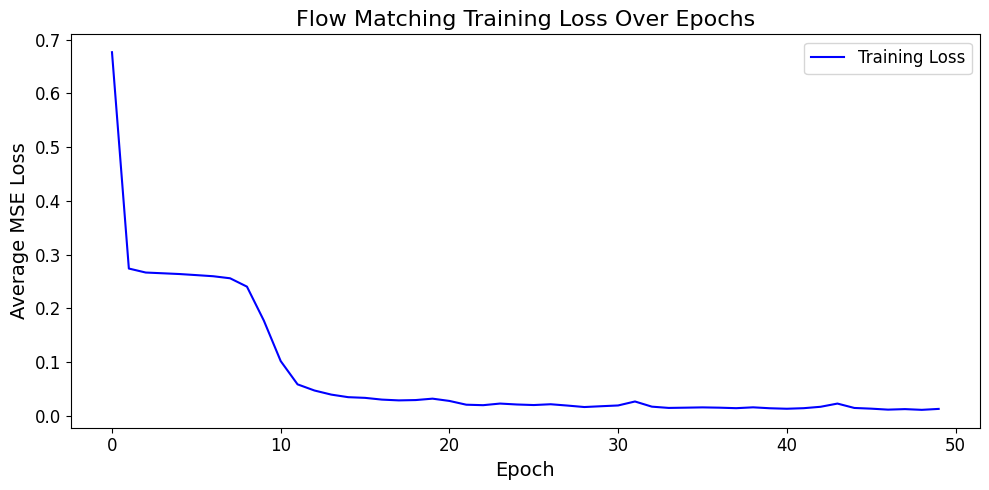

In [7]:
plt.figure(figsize=(10, 5))

plt.plot(loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Average MSE Loss', fontsize=14)
plt.title('Flow Matching Training Loss Over Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


In [8]:
@torch.no_grad()
def rk4_integration(model, x_init, t0=1.0, t1=0.0, steps=80):
    model.eval()
    x = x_init.clone()
    B = x.size(0)

    dt = (t1 - t0) / steps
    t = t0

    for _ in range(steps):
        t_vec = torch.full((B,), t, device=x.device)

        k1 = model(x, t_vec)
        k2 = model(x + 0.5 * dt * k1, t_vec + 0.5 * dt)
        k3 = model(x + 0.5 * dt * k2, t_vec + 0.5 * dt)
        k4 = model(x + dt * k3, t_vec + dt)

        x = x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        t = t + dt

    return x

@torch.no_grad()
def sample(model, n=16, steps=80, latent_std=0.5):
    z = torch.randn(n, 1, 64, 64, device=device) * latent_std
    x = rk4_integration(model, z, steps=steps)
    return x

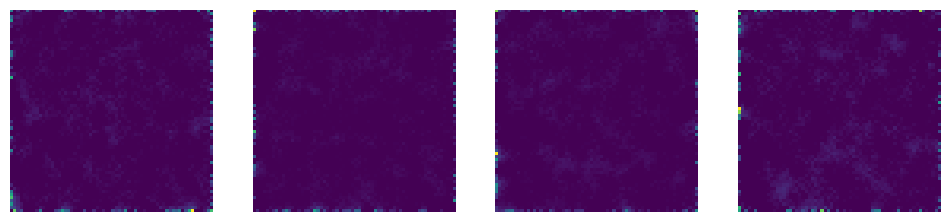

In [ ]:
samples = sample(model, n=4)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = (samples[i].clamp(-1, 1) + 1) / 2
    axs[i].imshow(img.squeeze().cpu())
    axs[i].axis("off")

plt.show()


In [11]:
print(samples)

tensor([[[[-0.8011, -1.3716, -0.9519,  ..., -0.9956, -0.7818, -1.2206],
          [-1.0295, -1.0027, -0.9894,  ..., -0.9891, -0.9505, -0.8005],
          [-0.8497, -0.9747, -0.9637,  ..., -0.9779, -0.9818, -1.0633],
          ...,
          [-0.7564, -0.9349, -0.9569,  ..., -0.9926, -0.9992, -0.8655],
          [-0.8806, -0.9042, -0.9438,  ..., -0.9851, -0.9622, -1.2106],
          [-1.1782, -0.6441, -0.9345,  ..., -0.9705, -0.8526, -0.6741]]],


        [[[-0.3352, -1.1655, -1.1156,  ..., -0.9893, -1.0882, -1.2640],
          [-0.9160, -0.9881, -0.9931,  ..., -0.9890, -0.9832, -1.0835],
          [-1.0446, -1.0169, -0.9987,  ..., -0.9908, -0.9894, -1.0228],
          ...,
          [-1.1351, -1.0096, -1.0080,  ..., -1.0363, -1.0351, -1.0899],
          [-1.1651, -1.0113, -0.9995,  ..., -1.0601, -1.0536, -1.2240],
          [-1.1624, -0.9288, -1.0325,  ..., -1.1315, -1.2898, -1.4149]]],


        [[[-0.4758, -0.8739, -0.9496,  ..., -0.9657, -1.0600, -0.4520],
          [-1.2341, -0.969